# Data preparation

In [2]:
import pandas as pd

# Load your dataset
df = pd.read_csv('syntheticQDstructure.csv')
print(df.head())
print("Shape:", df.shape)

  core_composition ligand_composition  size (nm)  band_gap (eV)  \
0             InAs               TDPA        3.6           0.82   
1             ZnSe      Zinc stearate        3.8           3.07   
2             PbSe                MPA        6.9           1.06   
3              ZnS     Hexadecylamine        2.3           3.98   
4              InP                TOP        6.3           1.94   

   quantum_yield (%)  emission_maximum (nm) lattice_type  a (Å)  b (Å)  c (Å)  \
0                 64                    904  Zinc Blende   6.06   6.06   6.06   
1                 71                    544  Zinc Blende   5.67   5.67   5.67   
2                 32                    905    Rock Salt   6.12   6.12   6.12   
3                 45                    442        Cubic   5.41   5.41   5.41   
4                 70                    634  Zinc Blende   5.87   5.87   5.87   

   alpha (°)  beta (°)  gamma (°)  volume (Å³)  
0       90.0      90.0       90.0       222.55  
1       90.0

In [3]:
df_encoded = pd.get_dummies(df)
print(df_encoded.head())
print("Encoded Shape:", df_encoded.shape)

   size (nm)  band_gap (eV)  quantum_yield (%)  emission_maximum (nm)  a (Å)  \
0        3.6           0.82                 64                    904   6.06   
1        3.8           3.07                 71                    544   5.67   
2        6.9           1.06                 32                    905   6.12   
3        2.3           3.98                 45                    442   5.41   
4        6.3           1.94                 70                    634   5.87   

   b (Å)  c (Å)  alpha (°)  beta (°)  gamma (°)  ...  ligand_composition_OLA  \
0   6.06   6.06       90.0      90.0       90.0  ...                   False   
1   5.67   5.67       90.0      90.0       90.0  ...                   False   
2   6.12   6.12       90.0      90.0       90.0  ...                   False   
3   5.41   5.41       90.0      90.0       90.0  ...                   False   
4   5.87   5.87       90.0      90.0       90.0  ...                   False   

   ligand_composition_Oleic acid  liga

In [4]:
import torch

X_array = df_encoded.to_numpy(dtype='float32')
X_tensor = torch.tensor(X_array)

# Autoencoder

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Define model, loss, optimizer
input_dim = X_tensor.shape[1]
latent_dim = 2  # small latent space for quantum training
model = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

autoencoder_train_losses = []

# Train autoencoder
for epoch in range(50):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        recon = model(batch[0])
        loss = criterion(recon, batch[0])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    avg_loss = total_loss / len(loader)
    autoencoder_train_losses.append(avg_loss)

# Save encoded data
with torch.no_grad():
    encoded_data = model.encoder(X_tensor).numpy()
    
print("Encoded Data Shape:", encoded_data.shape)
print("Encoded Data Sample:", encoded_data[:5])

Epoch 1, Loss: 61438.3574
Epoch 2, Loss: 58338.4209
Epoch 3, Loss: 58550.1260
Epoch 4, Loss: 61346.1914
Epoch 5, Loss: 45155.4805
Epoch 6, Loss: 33022.2812
Epoch 7, Loss: 21243.6250
Epoch 8, Loss: 7334.1228
Epoch 9, Loss: 3318.7446
Epoch 10, Loss: 2834.1181
Epoch 11, Loss: 2747.8796
Epoch 12, Loss: 2361.5390
Epoch 13, Loss: 1690.7256
Epoch 14, Loss: 944.7327
Epoch 15, Loss: 849.1803
Epoch 16, Loss: 1007.7478
Epoch 17, Loss: 945.1695
Epoch 18, Loss: 812.3510
Epoch 19, Loss: 762.8255
Epoch 20, Loss: 700.2889
Epoch 21, Loss: 658.3875
Epoch 22, Loss: 680.8297
Epoch 23, Loss: 601.2818
Epoch 24, Loss: 602.8920
Epoch 25, Loss: 545.2143
Epoch 26, Loss: 564.4838
Epoch 27, Loss: 562.3438
Epoch 28, Loss: 586.1644
Epoch 29, Loss: 532.6647
Epoch 30, Loss: 557.9025
Epoch 31, Loss: 584.3866
Epoch 32, Loss: 492.0880
Epoch 33, Loss: 533.2705
Epoch 34, Loss: 513.0727
Epoch 35, Loss: 493.3662
Epoch 36, Loss: 542.7070
Epoch 37, Loss: 590.0436
Epoch 38, Loss: 496.6936
Epoch 39, Loss: 495.4221
Epoch 40, Los

# Data convertion into bitstrings

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
encoded_normalized = scaler.fit_transform(encoded_data)  # shape: (N, 2)


In [7]:
def float_to_bits(x, n_bits=4):
    """Convert a float in [0,1] to fixed-length binary string"""
    max_int = 2**n_bits - 1
    int_val = int(x * max_int)
    return format(int_val, f'0{n_bits}b')

n_bits = 4  # bits per latent dimension
bitstrings = []

for point in encoded_normalized:
    bits = ''.join(float_to_bits(x, n_bits) for x in point)
    bitstrings.append(bits)

print("Bitstrings Sample:", bitstrings[:5])

Bitstrings Sample: ['11001100', '00110010', '11001100', '00000000', '01010101']


# QCBM

In [8]:
from qiskit import QuantumCircuit
import numpy as np

def create_qcbm_circuit(num_qubits, parameters):
    qc = QuantumCircuit(num_qubits)
    idx = 0
    for i in range(num_qubits):
        qc.ry(parameters[idx], i)
        idx += 1
        qc.rz(parameters[idx], i)
        idx += 1
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    return qc


In [9]:
from qiskit.primitives import StatevectorSampler
from scipy.optimize import minimize
from collections import Counter

sampler = StatevectorSampler()
qcbm_train_losses = []

def compute_kl_divergence(p_data, p_model, epsilon=1e-8):
    # Ensure support match
    keys = set(p_data.keys()).union(set(p_model.keys()))
    return sum(
        p_data.get(k, 0) * np.log((p_data.get(k, epsilon) + epsilon) / (p_model.get(k, epsilon) + epsilon))
        for k in keys
    )

def evaluate_qcbm_loss(parameters, num_qubits, target_distribution):
    qc = create_qcbm_circuit(num_qubits, parameters)
    # Add measurements
    qc.measure_all()
    result = sampler.run([qc]).result()
    # In Qiskit 2.x, the result format is different
    pub_result = result[0]  # Get the first (and only) pub result
    bit_array = pub_result.data.meas
    counts = dict(bit_array.get_counts())
    # Normalize output - keys are already strings
    total_shots = sum(counts.values())
    model_distribution = {k: v / total_shots for k, v in counts.items()}
    loss = compute_kl_divergence(target_distribution, model_distribution)
    qcbm_train_losses.append(loss)
    return loss

def compute_data_distribution(binary_encoded_data):
    str_data = [''.join(str(bit) for bit in sample) for sample in binary_encoded_data]
    counts = Counter(str_data)
    total = sum(counts.values())
    return {k: v / total for k, v in counts.items()}

In [10]:
# Convert bitstrings to binary array format
binary_encoded_data = np.array([[int(bit) for bit in bitstring] for bitstring in bitstrings])

num_qubits = binary_encoded_data.shape[1]
num_parameters = 2 * num_qubits
initial_params = np.random.uniform(0, 2 * np.pi, num_parameters)

target_distribution = compute_data_distribution(binary_encoded_data)

result = minimize(
    evaluate_qcbm_loss,
    x0=initial_params,
    args=(num_qubits, target_distribution),
    method='COBYLA',
    options={'maxiter': 100}
)

trained_params = result.x
print(f"Optimization completed. Final loss: {result.fun}")
print(f"Number of qubits: {num_qubits}")
print(f"Target distribution (first 5 items): {dict(list(target_distribution.items())[:5])}")

Optimization completed. Final loss: 3.6599787217325472
Number of qubits: 8
Target distribution (first 5 items): {'11001100': 0.14, '00110010': 0.01, '00000000': 0.11, '01010101': 0.02, '00010001': 0.1}


In [11]:
qc_trained = create_qcbm_circuit(num_qubits, trained_params)
qc_trained.measure_all()
result = sampler.run([qc_trained], shots=1000).result()

# Get the counts and convert to distribution
pub_result = result[0]
bit_array = pub_result.data.meas
counts = dict(bit_array.get_counts())
total_shots = sum(counts.values())
samples = {k: v / total_shots for k, v in counts.items()}

# Sort samples by probability
sorted_samples = sorted(samples.items(), key=lambda x: x[1], reverse=True)
top_samples = [k for k, _ in sorted_samples[:10]]
decoded_inputs = [np.array([int(bit) for bit in s]) for s in top_samples]

print("Top 10 most probable samples:")
for i, (sample, prob) in enumerate(sorted_samples[:10]):
    print(f"{i+1}. {sample}: {prob:.4f}")

Top 10 most probable samples:
1. 00000011: 0.0470
2. 11100011: 0.0430
3. 11111101: 0.0330
4. 11110011: 0.0310
5. 00011100: 0.0310
6. 11111100: 0.0290
7. 00011101: 0.0280
8. 00010011: 0.0230
9. 11111111: 0.0220
10. 00001100: 0.0200


# Data convertion back into the original format

In [12]:
# Convert bit strings back to 2D latent space format
def bits_to_float(bits, n_bits=4):
    """Convert binary string to float in [0,1]"""
    max_int = 2**n_bits - 1
    int_val = int(bits, 2)
    return int_val / max_int

# Convert the top samples back to 2D latent vectors
latent_vectors = []
for sample in top_samples:
    # Split the 8-bit string into two 4-bit parts
    bits_dim1 = sample[:4]  # First 4 bits
    bits_dim2 = sample[4:]  # Last 4 bits
    
    # Convert back to floats in [0,1]
    float_dim1 = bits_to_float(bits_dim1, n_bits)
    float_dim2 = bits_to_float(bits_dim2, n_bits)
    
    latent_vectors.append([float_dim1, float_dim2])

# Convert to tensor with proper scaling (inverse of normalization)
latent_tensor = torch.tensor(latent_vectors, dtype=torch.float32)
# Scale back to original latent space range using the fitted scaler
latent_scaled = scaler.inverse_transform(latent_tensor.numpy())
latent_scaled_tensor = torch.tensor(latent_scaled, dtype=torch.float32)

model.decoder.eval()  # Set to eval mode (no dropout/batchnorm)

with torch.no_grad():
    reconstructed_outputs = model.decoder(latent_scaled_tensor)
    
synthetic_results = reconstructed_outputs.numpy()
print("Synthetic results shape:", synthetic_results.shape)
print("Synthetic results sample:", synthetic_results[:3])
print("Latent vectors shape:", latent_scaled_tensor.shape)
print("Latent vectors sample:", latent_scaled_tensor[:3])

Synthetic results shape: (10, 34)
Synthetic results sample: [[ 6.49713159e-01 -1.65777218e+00  3.50584641e+01  5.51549072e+02
   3.19172406e+00  5.12061310e+00  2.19266796e+00  5.37697487e+01
   6.65922699e+01  6.32834816e+01  1.43755447e+02  7.77546287e-01
  -5.15228987e+00 -1.00235128e+00  7.11174488e-01 -1.92865264e+00
  -4.87807423e-01 -8.90649736e-01 -3.80528522e+00 -1.99344063e+00
   9.36328769e-01 -1.23013365e+00  1.22051775e+00  2.80436659e+00
  -3.10803413e+00  1.60893142e+00 -2.21837926e+00  1.52040076e+00
  -2.13737845e+00  2.28967547e+00  2.86231518e-01  1.23775673e+00
  -1.59752071e+00  2.91092062e+00]
 [ 1.83805733e+01  2.19054089e+01  5.95287666e+01  6.02890869e+02
   1.19700480e+01  5.66387463e+00  1.88167534e+01  1.36229752e+02
   8.61437836e+01  1.06071083e+02  1.93523880e+02 -4.97992754e-01
   2.46409092e+01  5.90643930e+00 -4.01712894e+00  9.14612103e+00
   4.57248402e+00  6.39786959e+00  1.92254047e+01  1.42863340e+01
  -1.82943428e+00  7.40689754e+00 -5.14895105e+

In [13]:

categorical_cols = ['core_composition', 'ligand_composition', 'lattice_type']

dummy_columns = [col for col in df_encoded.columns if any(col.startswith(cat + '_') for cat in categorical_cols)]
synthetic_df = pd.DataFrame(synthetic_results, columns=df_encoded.columns)
for col in categorical_cols:
    # Extract relevant dummy columns
    dummy_subset = synthetic_df[[c for c in synthetic_df.columns if c.startswith(col + '_')]]
    
    # Find argmax (i.e., the "1") to get back the original category
    synthetic_df[col] = dummy_subset.idxmax(axis=1).str.replace(col + '_', '')

    # Drop the dummy columns
    synthetic_df.drop(columns=dummy_subset.columns, inplace=True)
    
column_order = df.columns.tolist()
synthetic_df = synthetic_df.reindex(columns=column_order)

print("Synthetic DataFrame head:")
print(synthetic_df.head())

Synthetic DataFrame head:
  core_composition ligand_composition  size (nm)  band_gap (eV)  \
0              CdS                 OA   0.649713      -1.657772   
1             CdSe                OLA  18.380573      21.905409   
2             ZnSe                TOP   6.478503       4.444403   
3             CdSe                OLA  19.487988      23.368769   
4             InAs                 OA  -9.935502     -17.204372   

   quantum_yield (%)  emission_maximum (nm) lattice_type      a (Å)     b (Å)  \
0          35.058464             551.549072  Zinc Blende   3.191724  5.120613   
1          59.528767             602.890869    Rock Salt  11.970048  5.663875   
2          65.402168             927.847656    Rock Salt   7.835781  8.361627   
3          61.025814             607.036377    Rock Salt  12.487812  5.546422   
4          40.519310             844.376831  Zinc Blende  -0.466417  7.552464   

       c (Å)   alpha (°)    beta (°)   gamma (°)  volume (Å³)  
0   2.192668   53.76

In [14]:
synthetic_df.to_csv("synthetic_results.csv", index=False)

# Plots

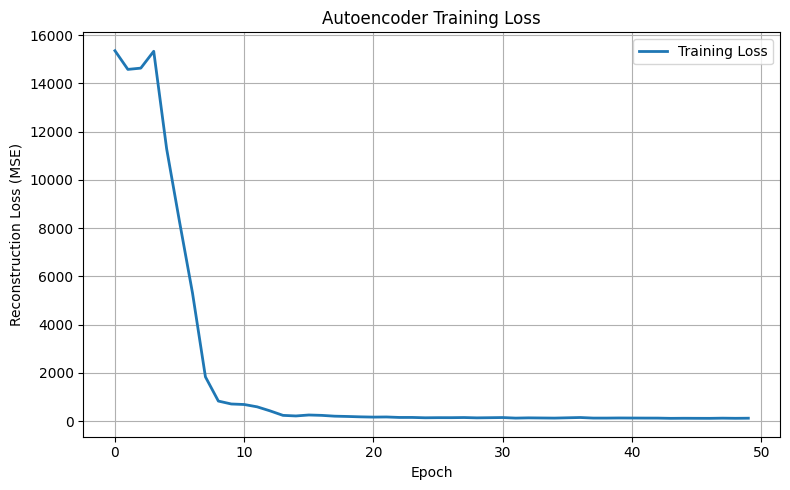

<Figure size 640x480 with 0 Axes>

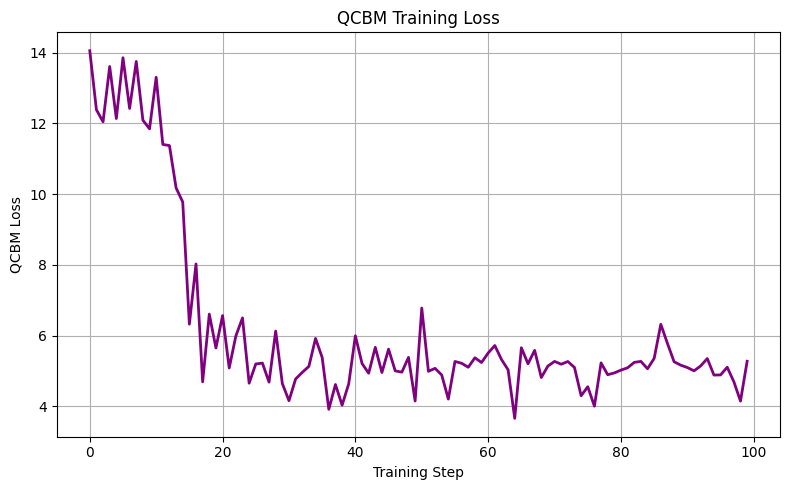

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

def plot_autoencoder_loss(train_losses, val_losses=None):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", linewidth=2)
    if val_losses is not None:
        plt.plot(val_losses, label="Validation Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Loss (MSE)")
    plt.title("Autoencoder Training Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig("autoencoder_training_loss.png")

def plot_qcbm_training_loss(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, color='purple', linewidth=2)
    plt.xlabel("Training Step")
    plt.ylabel("QCBM Loss")
    plt.title("QCBM Training Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig("qcbm_training_loss.png")

plot_autoencoder_loss(autoencoder_train_losses)
plot_qcbm_training_loss(qcbm_train_losses)

In [16]:
# Fixed novelty score computation
from scipy.spatial.distance import cdist
import numpy as np

def compute_novelty_scores(generated_latents, train_latents):
    """
    For each generated latent vector, compute the minimum distance to any train latent vector.
    """
    distances = cdist(generated_latents, train_latents, metric='euclidean')
    novelty_scores = np.min(distances, axis=1)  # Closest training example
    return novelty_scores

# Use detach().numpy() to convert tensor to numpy array without gradients
with torch.no_grad():
    train_latents = model.encoder(X_tensor).detach().numpy()

novelty_scores = compute_novelty_scores(latent_scaled, train_latents)
print(f"Novelty scores computed for {len(novelty_scores)} generated samples")
print(f"Mean novelty score: {np.mean(novelty_scores):.4f}")
print(f"Min novelty score: {np.min(novelty_scores):.4f}")
print(f"Max novelty score: {np.max(novelty_scores):.4f}")

Novelty scores computed for 10 generated samples
Mean novelty score: 54.6148
Min novelty score: 0.0000
Max novelty score: 105.8241


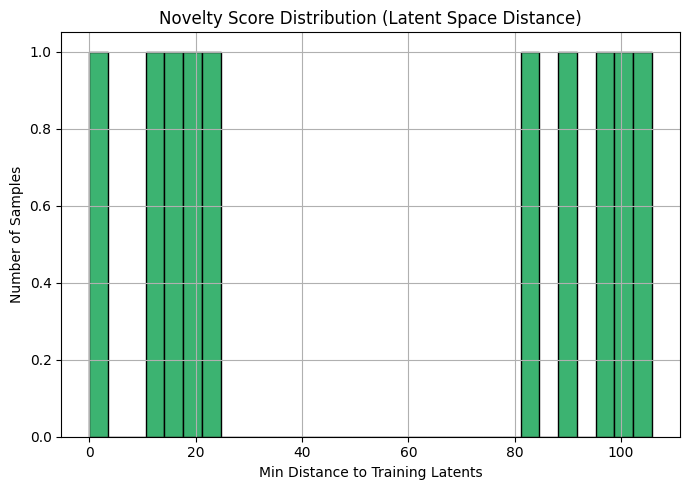

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

def plot_novelty_scores(novelty_scores):
    plt.figure(figsize=(7, 5))
    plt.hist(novelty_scores, bins=30, color='mediumseagreen', edgecolor='black')
    plt.title("Novelty Score Distribution (Latent Space Distance)")
    plt.xlabel("Min Distance to Training Latents")
    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig("novelty_scores_distribution.png")

plot_novelty_scores(novelty_scores)


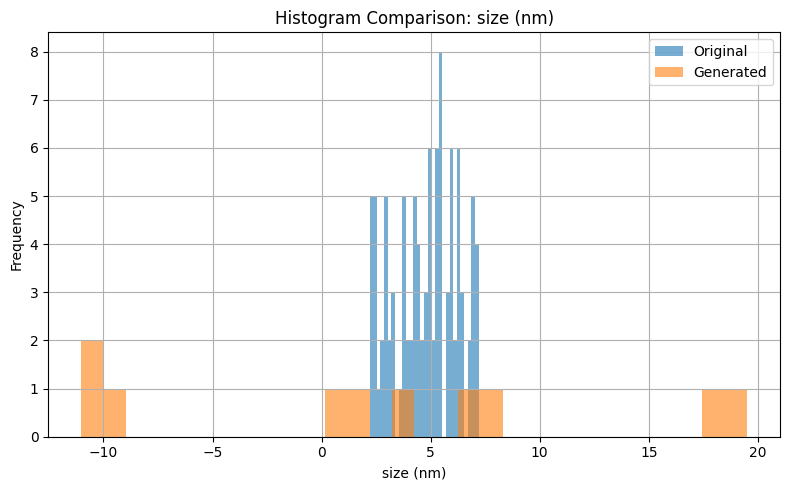

<Figure size 640x480 with 0 Axes>

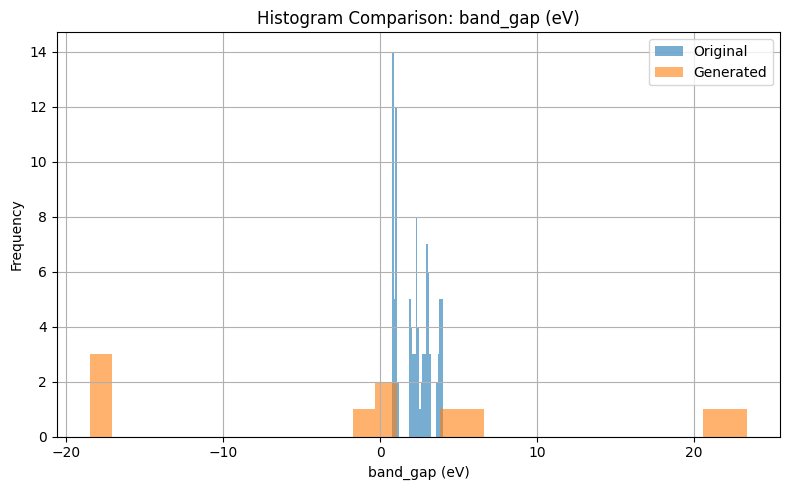

<Figure size 640x480 with 0 Axes>

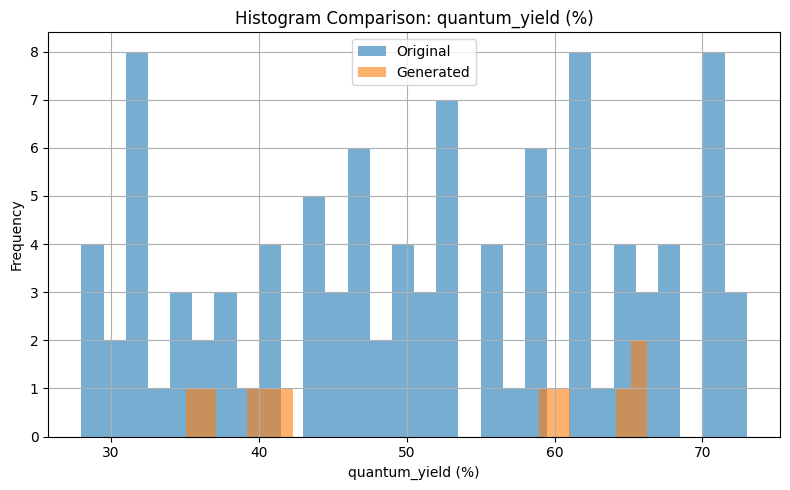

<Figure size 640x480 with 0 Axes>

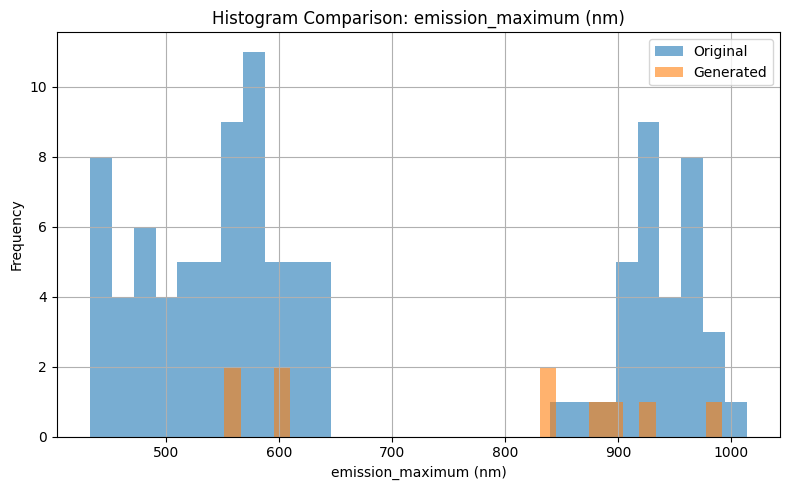

<Figure size 640x480 with 0 Axes>

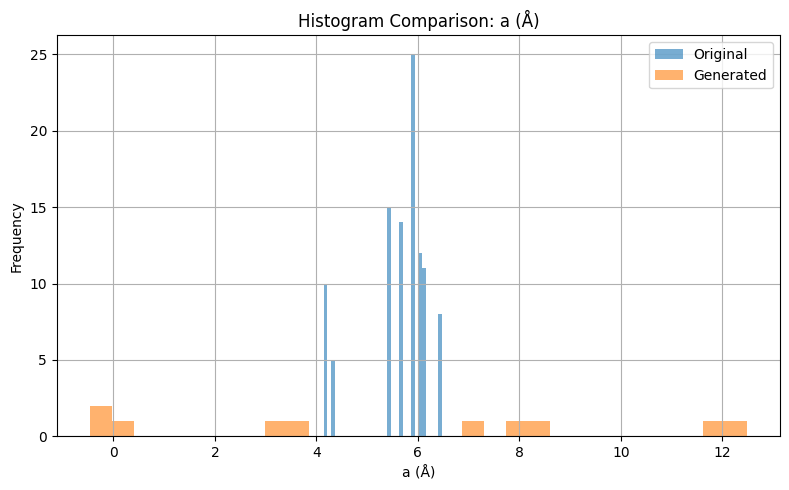

<Figure size 640x480 with 0 Axes>

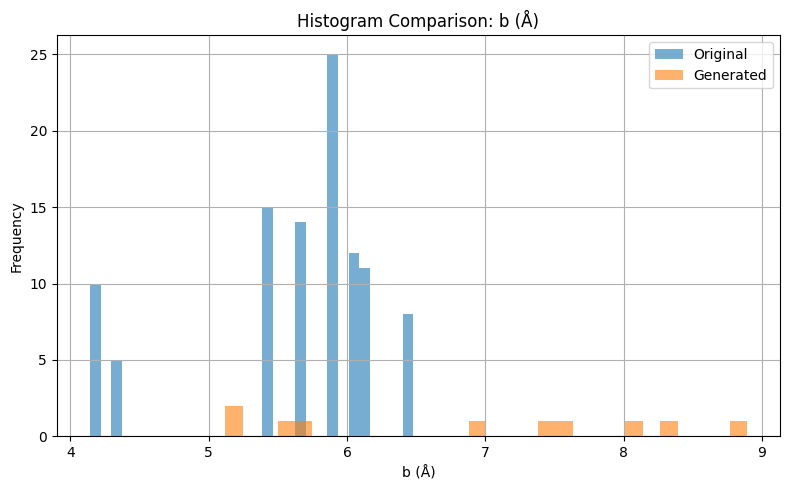

<Figure size 640x480 with 0 Axes>

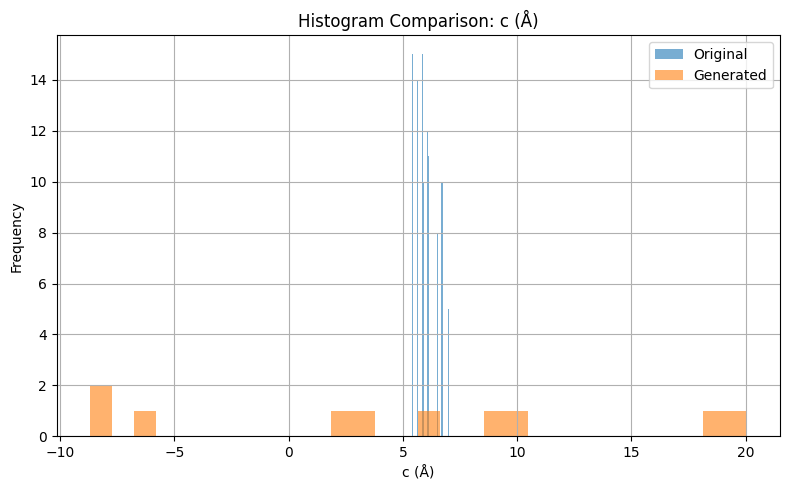

<Figure size 640x480 with 0 Axes>

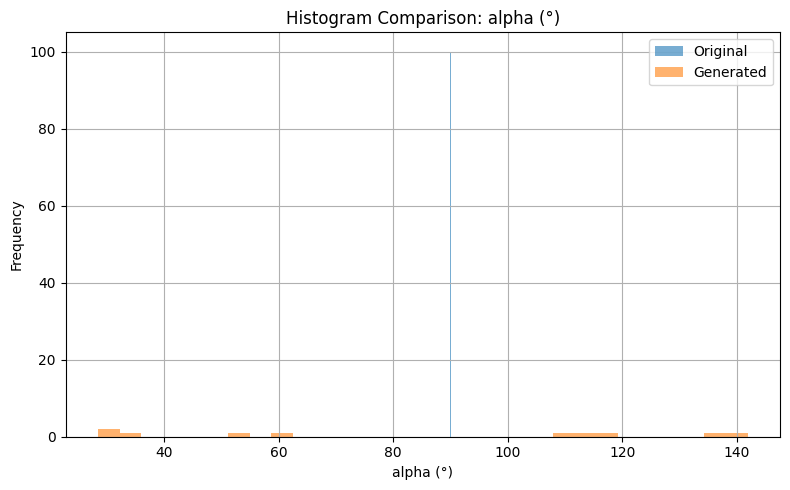

<Figure size 640x480 with 0 Axes>

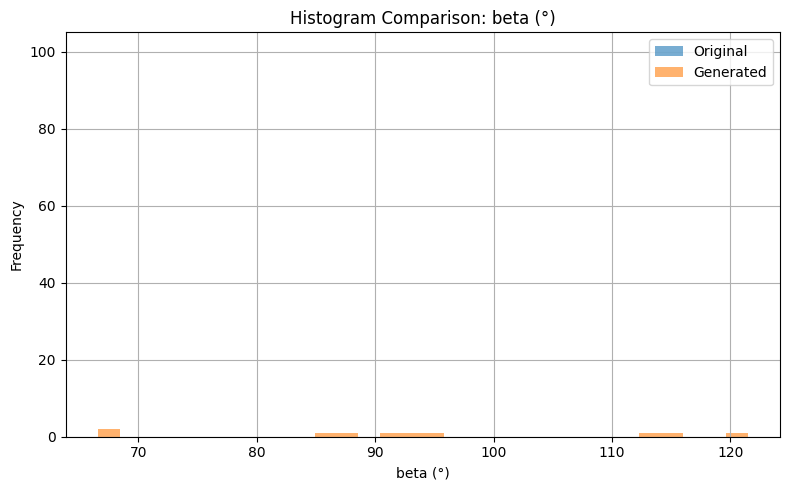

<Figure size 640x480 with 0 Axes>

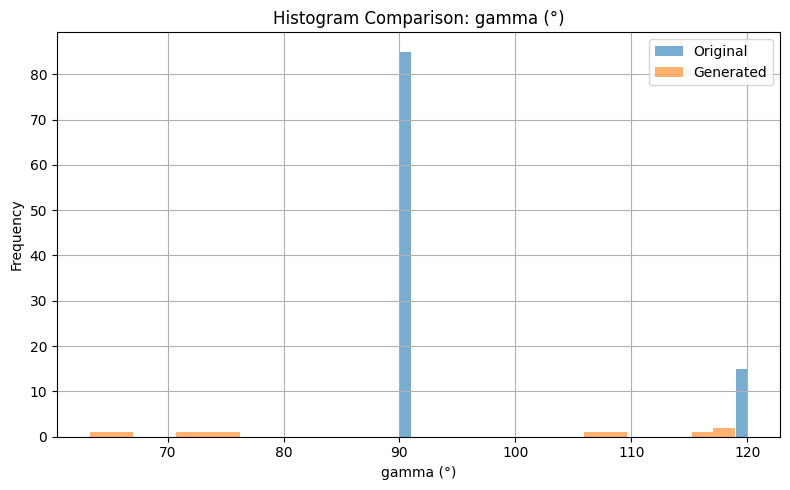

<Figure size 640x480 with 0 Axes>

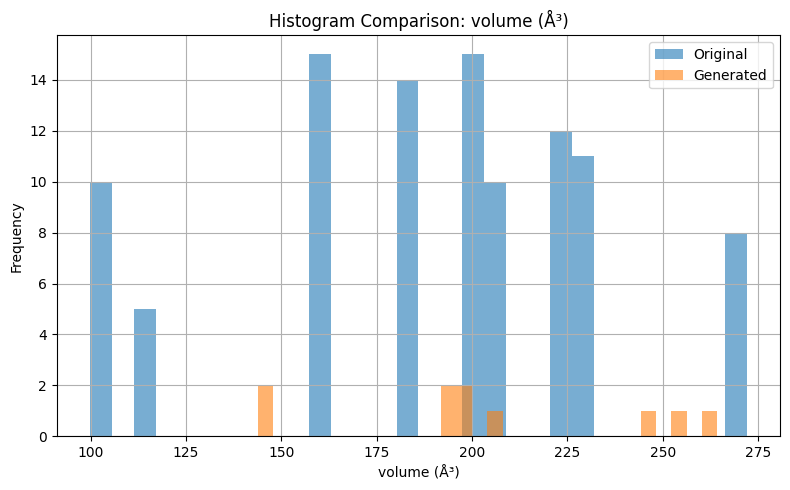

<Figure size 640x480 with 0 Axes>

In [18]:
def compare_histograms(original, generated, column):
    plt.figure(figsize=(8, 5))
    plt.hist(original[column], bins=30, alpha=0.6, label="Original")
    plt.hist(generated[column], bins=30, alpha=0.6, label="Generated")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.title(f"Histogram Comparison: {column}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"histogram_comparison_{column}.png")
    
for column in df.columns:
    if column not in categorical_cols:  # Skip categorical columns
        compare_histograms(df, synthetic_df, column)    